## <center> Data Preparation </center>

Sample data: 

* 
> “A-M-A-ZING!!!!!!!!!!!!!! LOVE THIS PLACE!!!!!!! Everything on the menu looked so good!! Garlic chicken was the BOMB!!!!!! MUST EAT AT THIS PLACE!!! I recommend ordering ahead before you go! Gets very busy!!!” — 5 Stars.

* 
> “burgers are very big portions here. definitely order the onion ring tower to share…Milkshakes are tasty! My personal favourite — the vanilla one.” — 3 Stars.

* 
> “Food is very bland — not authentic at all. meant to cater to the customers who have never eaten Vietnamese food before. Definitely will not be returning!” — 1 Stars

The first part of the project is to prepare the data. As we saw in the examples above, the reviews are very distinct. 
* Some of them have symbols, 
* have weird punctuation symbols, 
* and some even have non-alphanumeric characters. 

We will clean these and keep the most relevant strings and words from the reviews. 

## Importing libraries

Importing necessary libraries to assist us in data preparation

In [8]:
import pandas as pd    # to create a dataframe from JSON datafile
import json            # to read the dataset, because dataset is initially in the JSON format
import numpy as np     # to handle large python list as numpy arrays - makes the process faster. Used in creating dataFrame
import matplotlib.pyplot as plt # to draw plot - for visualization
from collections import Counter # to counter class distribution in the dataset

pd.set_option('max_colwidth', 300,"html.border",2)  # For aesthetic purposes
from IPython.display import display, HTML           # For aesthetic purposes

## Read the dataset

The dataset downloaded from yelp is in JSON format as below:  
    
* > {"review_id":"v0i_UHJMo_hPBq9bxWvW4w","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"0W4lkclzZThpx3V65bVgig","stars":5,"date":"2016-05-28","text":"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.","useful":0,"funny":0,"cool":0}

* > {"review_id":"vkVSCC7xljjrAI4UGfnKEQ","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"AEx2SYEUJmTxVVB18LlCwA","stars":5,"date":"2016-05-28","text":"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.","useful":0,"funny":0,"cool":0}

It is  a 4.2G file - *review.json* 

I plan to just read the *text* and *stars* from the review and build a pandas dataset out of it.

Let's do this.

In [38]:
def readData(reviewJsonFilePath, outputDataFrameFilePath):
    df = pd.DataFrame(columns=['review','stars'])
    reviews = []    # Aggregated list of reviews
    stars = []      # Aggregated list of stars
    with open(reviewJsonFilePath, "r") as f:
        number_of_records = 0
        for line in f:
            line = json.loads(line)
            reviews.append(line["text"])
            stars.append(line['stars'])
            number_of_records += 1
            
        df["review"] = reviews
        df["stars"] = stars
        
    print ("Number of records read : {0}".format(number_of_records))      
    print ("Sample data : ")
    display(df.head())
    return df
                
            
reviewJsonFilePath = "../data/review.json"
outputDataFrameFilePath = "../data/dataset.csv"
df = readData(reviewJsonFilePath, outputDataFrameFilePath)            

Number of records read : 5261669
Sample data : 


,review,stars
0,"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.",5
1,Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.,5
2,Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how...,5
3,Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the inside. \n\nThe smoked meat is up there in quali...,5
4,"Love coming here. Yes the place always needs the floor swept but when you give out peanuts in the shell how won't it always be a bit dirty. \n\nThe food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger ...",4


In [39]:
## Saving the dataset file onto disk for future use
df.to_csv(outputDataFrameFilePath, index=False)

## Class distribution

Let us look at the class distribution of label - *stars* in our case

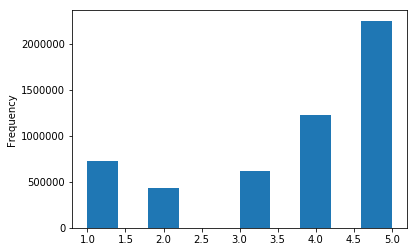

In [11]:
#df = pd.read_csv("../data/dataset.csv")
df['stars'].plot.hist()
plt.show()

In [12]:
c = Counter(df['stars'])
print (c)
print ("Percentage distribution of labels : ")
[(i, c[i] / len(df) * 100.0) for i in c]

Counter({5.0: 2253348, 4.0: 1223316, 1.0: 731363, 3.0: 615481, 2.0: 438161, nan: 1, nan: 1})
Percentage distribution of labels : 


[(nan, 1.900536920685463e-05),
 (1.0, 13.899823839232821),
 (2.0, 8.327411577044632),
 (3.0, 11.697443644804094),
 (4.0, 23.249572236652575),
 (5.0, 42.82571069152746),
 (nan, 1.900536920685463e-05)]

There is definately a class bias :
* 14% of the label values are for stars 1
* 8% of the label values for stars 2
* 12% of the label values for stars 3
* 23% of the label values for stars 4
* 42% of the label values for stars 5

